# Análise Exploratória - Pneumonia em Raio-X

Este notebook realiza uma análise exploratória do dataset de pneumonia em raio-X, focando em:

- Download do dataset do Kaggle
- Análise da estrutura de diretórios
- Estatísticas descritivas (número de imagens por classe)
- Visualização de amostras de imagens
- Análise de distribuição de classes
- Verificação de dimensões das imagens
- Análise de qualidade das imagens

## Dataset

O dataset utilizado é o **Chest X-Ray Images (Pneumonia)** do Kaggle, que contém imagens de raio-X de tórax classificadas em:
- **Normal**: Sem sinais de pneumonia
- **Pneumonia**: Com sinais de pneumonia


In [10]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from PIL import Image
import importlib

# Adicionar o diretório raiz do projeto ao sys.path
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

# Importar e recarregar módulos do projeto (para garantir que estamos usando a versão mais recente)
import src.vision.data_loader
importlib.reload(src.vision.data_loader)
from src.vision.data_loader import (
    download_pneumonia_dataset,
    load_image_dataset,
    get_class_distribution,
    validate_images,
    get_image_info
)

# Configuração
with open("../config.yaml", "r") as f:
    config = yaml.safe_load(f)

print("Módulos importados com sucesso!")


Módulos importados com sucesso!


## 1. Download do Dataset

Primeiro, vamos baixar o dataset do Kaggle usando kagglehub.


In [11]:
# Baixar dataset de pneumonia
dataset_path = download_pneumonia_dataset(
    target_path=config["data"]["images"]["pneumonia_path"]
)

print(f"\nDataset disponível em: {dataset_path}")


Baixando dataset de pneumonia em raio-X...
Dataset baixado em: /Users/vinicius/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2

Dataset disponível em: /Users/vinicius/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


## 2. Carregamento e Estrutura do Dataset

Vamos carregar as imagens e analisar a estrutura do dataset.


In [12]:
# Carregar dataset
# O dataset geralmente tem estrutura: train/NORMAL/, train/PNEUMONIA/, test/NORMAL/, test/PNEUMONIA/
df = load_image_dataset(dataset_path)

print(f"Total de imagens carregadas: {len(df)}")
print(f"\nPrimeiras linhas do DataFrame:")
print(df.head(10))

print(f"\nEstrutura do dataset:")
print(df.info())


Total de imagens carregadas: 5856

Primeiras linhas do DataFrame:
                                          image_path      label  split
0  /Users/vinicius/.cache/kagglehub/datasets/paul...  PNEUMONIA  train
1  /Users/vinicius/.cache/kagglehub/datasets/paul...  PNEUMONIA  train
2  /Users/vinicius/.cache/kagglehub/datasets/paul...  PNEUMONIA  train
3  /Users/vinicius/.cache/kagglehub/datasets/paul...  PNEUMONIA  train
4  /Users/vinicius/.cache/kagglehub/datasets/paul...  PNEUMONIA  train
5  /Users/vinicius/.cache/kagglehub/datasets/paul...  PNEUMONIA  train
6  /Users/vinicius/.cache/kagglehub/datasets/paul...  PNEUMONIA  train
7  /Users/vinicius/.cache/kagglehub/datasets/paul...  PNEUMONIA  train
8  /Users/vinicius/.cache/kagglehub/datasets/paul...  PNEUMONIA  train
9  /Users/vinicius/.cache/kagglehub/datasets/paul...  PNEUMONIA  train

Estrutura do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 3 columns):
 #   Column      Non-Nul

## 3. Análise da Distribuição de Classes

Vamos analisar a distribuição das classes em cada split (treino/teste/validação).


Distribuição de Classes por Split:
label  NORMAL  PNEUMONIA   All
split                         
test      234        390   624
train    1341       3875  5216
val         8          8    16
All      1583       4273  5856


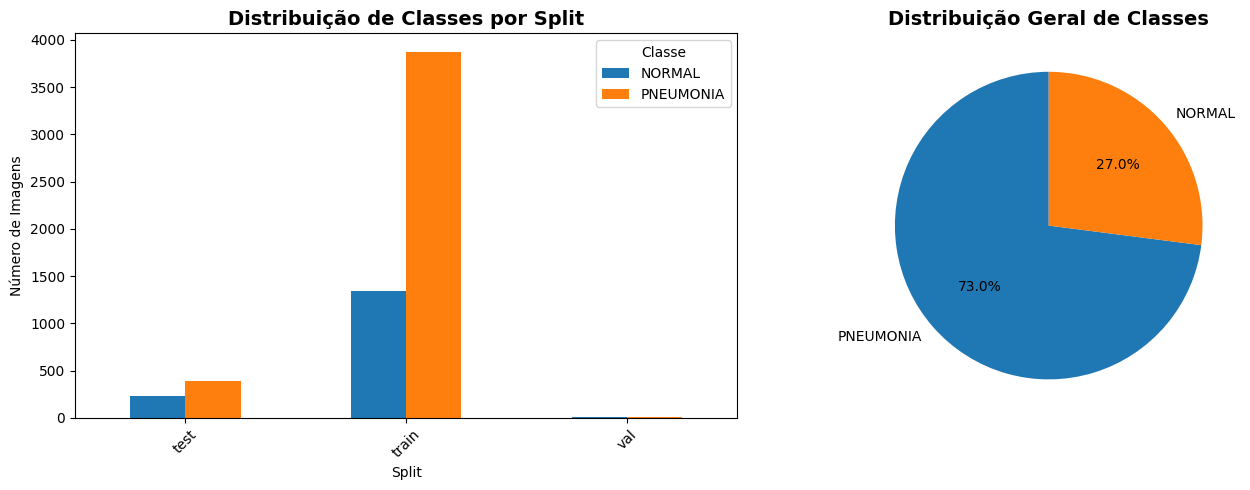

In [13]:
# Distribuição de classes
distribution = get_class_distribution(df, split_col='split')

print("Distribuição de Classes por Split:")
print("=" * 60)
print(distribution)

# Visualização
if 'split' in df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Gráfico de barras por split
    split_dist = pd.crosstab(df['split'], df['label'])
    split_dist.plot(kind='bar', ax=axes[0], stacked=False)
    axes[0].set_title('Distribuição de Classes por Split', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Split')
    axes[0].set_ylabel('Número de Imagens')
    axes[0].legend(title='Classe')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Gráfico de pizza geral
    label_counts = df['label'].value_counts()
    axes[1].pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%', startangle=90)
    axes[1].set_title('Distribuição Geral de Classes', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
else:
    # Se não houver split, apenas mostrar distribuição geral
    label_counts = df['label'].value_counts()
    print("\nDistribuição Geral:")
    print(label_counts)
    
    plt.figure(figsize=(8, 5))
    label_counts.plot(kind='bar')
    plt.title('Distribuição de Classes', fontsize=14, fontweight='bold')
    plt.xlabel('Classe')
    plt.ylabel('Número de Imagens')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


## 4. Visualização de Amostras

Vamos visualizar algumas amostras de imagens de cada classe.


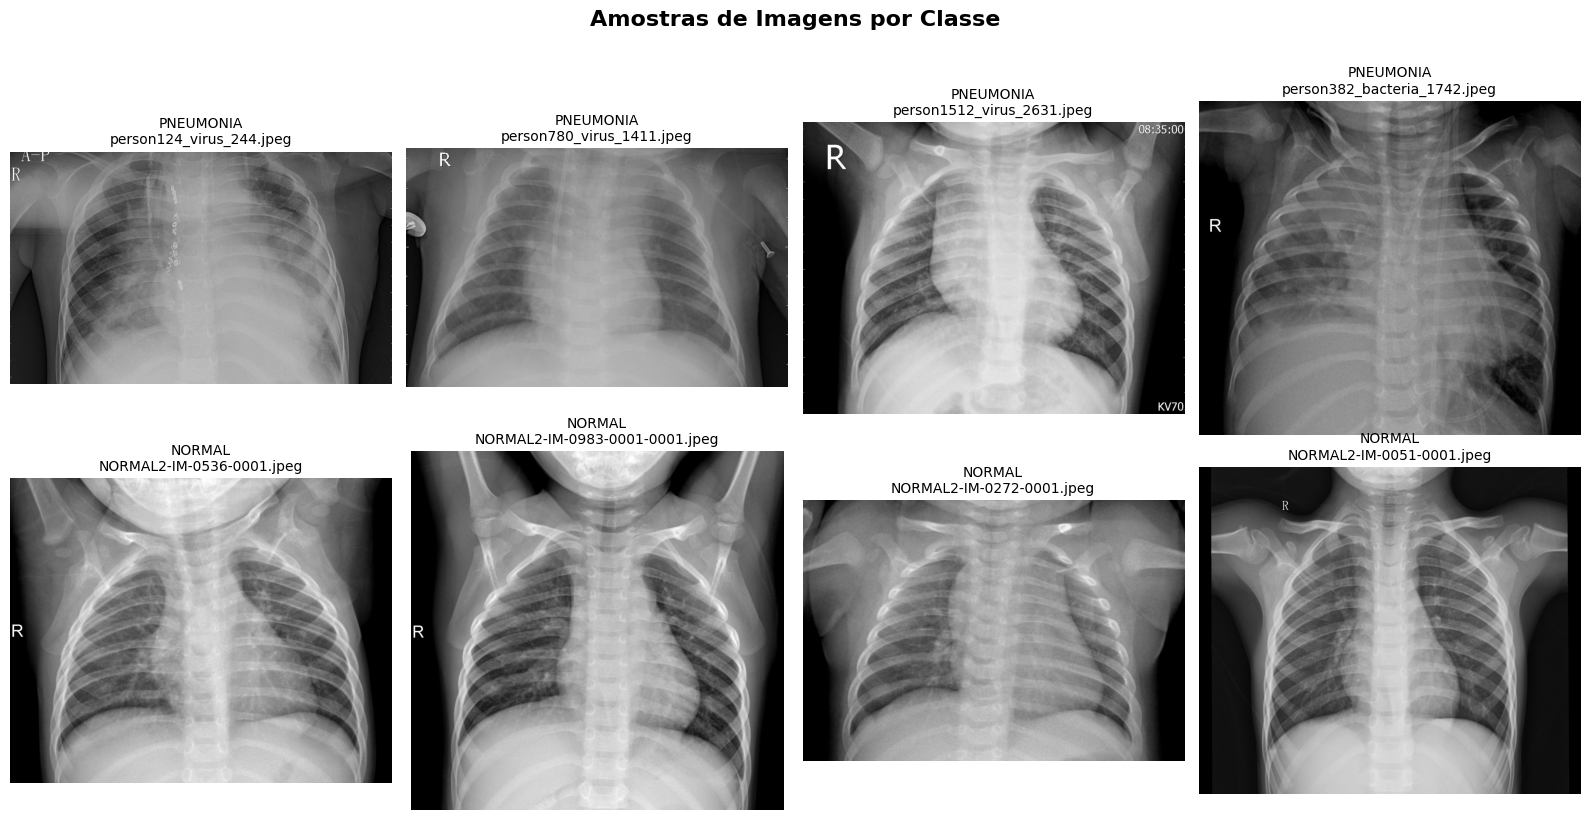

In [14]:
# Visualizar amostras de cada classe
classes = df['label'].unique()
num_samples_per_class = 4

fig, axes = plt.subplots(len(classes), num_samples_per_class, figsize=(16, 8))

for i, class_name in enumerate(classes):
    class_images = df[df['label'] == class_name].sample(num_samples_per_class, random_state=42)
    
    for j, (idx, row) in enumerate(class_images.iterrows()):
        try:
            img = Image.open(row['image_path'])
            axes[i, j].imshow(img, cmap='gray' if img.mode == 'L' else None)
            axes[i, j].set_title(f'{class_name}\n{Path(row["image_path"]).name}', fontsize=10)
            axes[i, j].axis('off')
        except Exception as e:
            axes[i, j].text(0.5, 0.5, f'Erro:\n{str(e)}', 
                          ha='center', va='center', transform=axes[i, j].transAxes)
            axes[i, j].axis('off')

plt.suptitle('Amostras de Imagens por Classe', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


## 5. Análise de Dimensões e Qualidade das Imagens

Vamos analisar as dimensões das imagens e verificar sua qualidade.


In [15]:
# Obter informações sobre as imagens
image_info = get_image_info(df, sample_size=min(500, len(df)))

print("Informações sobre as Imagens:")
print("=" * 60)
print(f"Total de imagens: {image_info['total_images']}")
print(f"\nDimensões médias (amostra de {min(500, len(df))} imagens):")
print(f"  Largura média: {image_info['width_mean']:.1f} ± {image_info['width_std']:.1f} pixels")
print(f"  Altura média: {image_info['height_mean']:.1f} ± {image_info['height_std']:.1f} pixels")
print(f"\nFormatos de arquivo:")
for fmt, count in image_info['formats'].items():
    print(f"  {fmt}: {count} imagens")


Informações sobre as Imagens:
Total de imagens: 5856

Dimensões médias (amostra de 500 imagens):
  Largura média: 1327.2 ± 360.6 pixels
  Altura média: 974.3 ± 393.6 pixels

Formatos de arquivo:
  JPEG: 500 imagens


## 6. Validação de Imagens

Vamos validar as imagens e remover arquivos corrompidos, se houver.


In [16]:
# Validar imagens (isso pode levar algum tempo)
print(f"Validando {len(df)} imagens...")
df_valid = validate_images(df)

print(f"\nImagens válidas: {len(df_valid)}")
print(f"Imagens removidas: {len(df) - len(df_valid)}")

# Atualizar DataFrame
df = df_valid.copy()


Validando 5856 imagens...

Imagens válidas: 5856
Imagens removidas: 0


## 7. Resumo e Próximos Passos

### Resumo da Análise Exploratória

- **Total de imagens**: {len(df)}
- **Classes**: {', '.join(df['label'].unique())}
- **Distribuição**: {df['label'].value_counts().to_dict()}

### Próximos Passos

1. Pré-processamento das imagens (redimensionamento, normalização)
2. Divisão dos dados em treino/validação/teste
3. Treinamento de modelos CNN
4. Avaliação e interpretabilidade
